In [249]:
import numpy as np
import pandas as pd
import math

#import import_ipynb
import nbimporter
from Scoring_Function import score

# Read csv into pandas dataframe
df = pd.read_csv('train_fixed.csv', low_memory=False)
pd.set_option('display.max_columns', None)

In [250]:
df = df.drop(['Unnamed: 0', 'GameId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
         'Dir', 'NflId', 'NflIdRusher', 'Position', 'DisplayName', 'JerseyNumber', 'Season', 
         'OffenseFormation', 'OffensePersonnel', 'DefensePersonnel', 
         'TimeHandoff', 'TimeSnap', 'PlayerHeight', 'PlayerWeight', 
         'PlayerBirthDate', 'PlayerCollegeName', 'Week', 'Stadium',
         'Location', 'StadiumType', 'Turf', 'GameWeather', 'WindDirection'], axis = 1)

df = df.drop_duplicates()

In [251]:
def calc_yards_to_go(row):
    if row['PossessionTeam'] == row['FieldPosition']:
        return 100 - row['YardLine']
    else:
        return row['YardLine']

df['YardsToGo'] = df.apply(lambda row: calc_yards_to_go(row), axis = 1)

In [252]:
df = df.drop(['GameClock', 'YardLine', 'PossessionTeam', 'FieldPosition', 
              'PlayDirection', 'HomeTeamAbbr', 'VisitorTeamAbbr', 'WindSpeed'], axis = 1)
df = df.fillna(df.mean())

df = df[df['Yards'] <= 10] # plays shorter than 10 yards

In [253]:
from sklearn.model_selection import train_test_split
train , test = train_test_split(df, test_size = 0.3)

x_train = train.drop(['Yards', 'PlayId'], axis=1)
y_train = train['Yards']

x_test = test.drop(['Yards', 'PlayId'], axis = 1)
y_test = test['Yards']

In [254]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)

x_test_scaled = scaler.fit_transform(x_test)
x_test = pd.DataFrame(x_test_scaled)

In [255]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
import matplotlib.pyplot as plt
%matplotlib inline

In [219]:
rmse_val = [] #to store rmse values for different k
for K in range(436, 437):
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(x_train, y_train)  #fit the model
    pred=model.predict(x_test) #make prediction on test set
    error = math.sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  436 is: 6.800564795674788


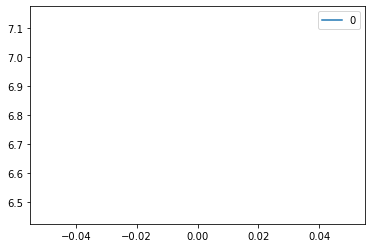

In [220]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

In [257]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors': [*range(1, 500, 1)]}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)
model.fit(x_train,y_train)
model.best_params_

{'n_neighbors': 301}

In [258]:
model = neighbors.KNeighborsRegressor(n_neighbors = model.best_params_['n_neighbors'])
model.fit(x_train, y_train)  #fit the model
pred=model.predict(x_test) #make prediction on test set
pred_round = np.around(pred)
pred_round

array([3., 3., 3., ..., 3., 3., 3.])

In [259]:
sample_sub = pd.read_csv('sample_submission.csv').rename(columns={"Unnamed: 0": "PlayId"}) #bring in sample sumbission
sub = sample_sub.set_index('PlayId').drop([0])
plays = pd.unique(test['PlayId'])

for i in range(plays.size):
    dist = np.histogram(pred_round[i], bins = 199, range = (-99, 99))[0] #find probability for each bin
    cumul_sum = np.cumsum(dist)
    sub.loc[plays[i]] = cumul_sum
sub = sub.reset_index()

In [210]:
sub

In [260]:
score(sub, df)

0.012185869815820621